In [1]:
#Importation des librairies

import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

import seaborn as sns
sns.set()

import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import t, shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels


from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

# Sklearn processing
from sklearn.model_selection import train_test_split, train_test_split , cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import pickle
import warnings
warnings.simplefilter("ignore")

In [2]:
#Upload de notre df_final
df_final= pd.read_csv('df_final.csv')

In [3]:
#Structure du df_final
df_final.shape

(1500, 7)

In [4]:
#Visualisation du df_final
df_final.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,171.81,104.86,104.95,4.52,2.89,112.83
1,1,171.46,103.36,103.66,3.77,2.99,113.09
2,1,172.69,104.48,103.50,4.40,2.94,113.16
3,1,171.36,103.91,103.94,3.62,3.01,113.51
4,1,171.73,104.28,103.46,4.04,3.48,112.54


# Séparation des données et standardisation des données 

Il est recommandé de normaliser ou standardiser les données avant de diviser l'ensemble de données en jeu d'entraînement et de test pour que toutes les variables soient à la même échelle et ainsi éviter les biais.

In [5]:
#On stocke les variables 
X = df_final[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']]
y = df_final['is_genuine']


In [6]:
#Séparation des données en training et test datasets

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.20,
    random_state=4)

#Initialisation du scaler
scaler = StandardScaler()

# On sauvegarde le modèle de scaler par soucis de best practices pour que toutes nos données soient scalées de la même manière
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
    

X_train_std = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns = X_train.columns
)

X_test_std = pd.DataFrame(
    scaler.transform(X_test),
    columns = X_test.columns)



# Modèle de régression logistique 

- La régression logistique explique une variable binaire qualitative. 
- L'utilisation de ce modèle est pertinente pour prédire les vrais et faux billets

In [7]:
# Modèle de regression logistique 
reg_log = LogisticRegression(solver='lbfgs', random_state=4, multi_class='auto')
reg_log.fit(X_train_std, y_train.values.ravel())

LogisticRegression(random_state=4)

In [8]:
#Matrice de confusion
from sklearn.metrics import confusion_matrix

y_pred = np.array(reg_log.predict(X_test_std))
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred),
                        columns=["Pred.Negative", "Pred.Positive"],
                        index=['Act.Negative', "Act.Positive"])
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
accuracy = round((tn+tp)/(tn+fp+fn+tp), 4)
print(conf_mat)
print(f'\n Accuracy = {round(100*accuracy, 2)}%')

              Pred.Negative  Pred.Positive
Act.Negative            103              2
Act.Positive              1            194

 Accuracy = 99.0%


### Visualisation de la performance du modèle de regression logistique avec la courbe ROC

La courbe ROC permet de visualiser la performance d'un modèle de classification binaire en fonction du seuil de classification.



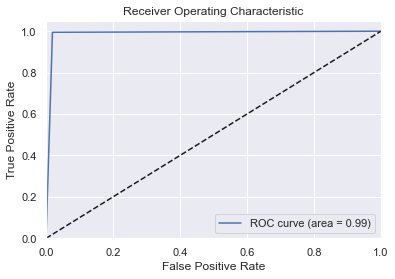

In [9]:
from sklearn.metrics import roc_curve, roc_auc_score

# Calcul de la courbe ROC et l'aire sous la courbe (AUC)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

# Affichage de la courbe ROC
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [10]:
print("L'AUC a un score de", round(auc,3))

L'AUC a un score de 0.988


- L'AUC a un score de 0.988 et donc très proche de 1
- Cela suggère que le modèle a une très bonne capacité à distinguer entre les deux classes du problème de classification.
- Il est capable de classer correctement la grande majorité des échantillons vrais et faux.
- Il y a une forte séparabilité entre les classes et une performance de prédiction élevée

### Matrice de confusion - regression logistique

In [11]:
from sklearn.metrics import confusion_matrix

y_pred = reg_log.predict(X_test_std)
confusion_matrix_reg_log = confusion_matrix(y_test, reg_log.predict(X_test_std))
print(confusion_matrix_reg_log) 

[[103   2]
 [  1 194]]


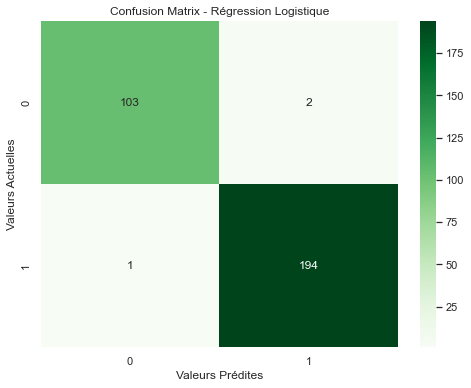

In [12]:
# Créer une figure pour le graphique de la matrice de confusion
plt.figure(figsize=(8, 6))

# Utiliser Seaborn pour afficher la matrice de confusion sous forme de heatmap
sns.heatmap(confusion_matrix_reg_log, annot=True, fmt="d", cmap="Greens")

# Ajouter des labels pour les axes x et y
plt.xlabel('Valeurs Prédites')
plt.ylabel('Valeurs Actuelles')

# Ajout d'un titre pour le graphique
plt.title('Confusion Matrix - Régression Logistique')

# Afficher le graphique
plt.show()

In [13]:
# Extraction des valeurs
tn1, fp1, fn1, tp1 = confusion_matrix_reg_log.ravel()

# Affichage
print('Vrais négatifs :', tn1)
print('Vrais positifs :', tp1)
print('Faux négatifs :', fn1)
print('Faux positifs :', fp1)

Vrais négatifs : 103
Vrais positifs : 194
Faux négatifs : 1
Faux positifs : 2


In [14]:
class_report = classification_report(y_test, y_pred)

In [15]:
print("Classification report:\n\n", class_report)

Classification report:

               precision    recall  f1-score   support

           0       0.99      0.98      0.99       105
           1       0.99      0.99      0.99       195

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



In [16]:
#On sauvegarde le modèle de regression logistique dans un fichier

with open('modele_regression_logistique.pkl', 'wb') as f:
    pickle.dump(reg_log, f)

# K-Means

K-means est un algorithme de clustering non supervisé utilisé pour partitionner un ensemble de données en k clusters en fonction de leur similarité.

## ACP

Il est préférable d'utiliser L'ACP qui permet de réduire la dimensionnalité des données et de faciliter l'interprétation des résultats de K-means.

In [17]:
#Pour cela, on enlève la colonne is_génuine
df_acp= df_final.drop("is_genuine", axis=1).copy()
df_acp.head()

,diagonal,height_left,height_right,margin_low,margin_up,length
0,171.81,104.86,104.95,4.52,2.89,112.83
1,171.46,103.36,103.66,3.77,2.99,113.09
2,172.69,104.48,103.50,4.40,2.94,113.16
3,171.36,103.91,103.94,3.62,3.01,113.51
4,171.73,104.28,103.46,4.04,3.48,112.54


In [18]:
#On convertit les données en array numpy
X = df_acp.values
X

array([[171.81, 104.86, 104.95,   4.52,   2.89, 112.83],
       [171.46, 103.36, 103.66,   3.77,   2.99, 113.09],
       [172.69, 104.48, 103.5 ,   4.4 ,   2.94, 113.16],
       ...,
       [171.8 , 104.01, 104.12,   5.51,   3.36, 111.95],
       [172.06, 104.28, 104.06,   5.17,   3.46, 112.25],
       [171.47, 104.15, 103.82,   4.63,   3.37, 112.07]])

In [19]:
df_acp.columns

Index(['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up',
       'length'],
      dtype='object')

In [20]:
#On utilise le modèle de scaler sauvegardé 
#On fit (ou adapte) nos données et on les transforme
X_scaled = scaler.fit_transform(X)

In [21]:
#Nombre de composantes
n_components = 2

In [22]:
#on instancie l'ACP
pca = PCA(n_components=n_components)

In [23]:
# Créer une instance de l'objet PCA
pca = PCA(n_components=2)

# Application de l'objet PCA sur les données standardisées
X_train_std=pca.fit_transform(X_scaled)
X_test_std=pca.transform(X_test)

#On initialise la variable scree comprenant les ratios de la variance
scree = (pca.explained_variance_ratio_*100).round(2)

print(scree)

[43.28 16.96]


In [24]:
#Calcul de la somme cumulée de la variance
scree_cum = scree.cumsum().round(2)
print(scree_cum)


[43.28 60.24]


- F1 explique ~ 43% de la variance
- F1 et F2 expliquent ~ 60% de la variance

In [25]:
#valeur corrigée
eigval = (df_acp.shape[0]-1)/df_acp.shape[0]*pca.explained_variance_
print(eigval)

[2.59704823 1.01738689]


In [26]:
sqrt_eigval = np.sqrt(eigval)

In [27]:
#corrélation des variables avec les axes
corvar = np.zeros((6,2))
for k in range(2):
   corvar[:,k] = pca.components_[k,:] * sqrt_eigval[k]
#affichage de la matrice des corrélations variables 
print(corvar)

[[-0.13644908  0.9494661 ]
 [ 0.53284329  0.31016723]
 [ 0.6342361   0.109243  ]
 [ 0.81807242 -0.07300199]
 [ 0.70825898 -0.00508627]
 [-0.84934046  0.04907254]]


In [28]:
#Initialisation d'une variable avec la liste de nos composantes :
x_list = (range(1, n_components+1),eigval)
list(x_list)

[range(1, 3), array([2.59704823, 1.01738689])]

### Cercle de corrélation

In [29]:
#Définition des axes x et y. 
#Comme - en code - on commence à compter à partir de 0, cela nous donne :

x_y = (0,1)
x_y

(0, 1)

In [30]:
#Détermination de la corrélation des variables par rapport aux nouveaux axes F1 et F2
df1=pd.DataFrame({'id':df_final.iloc[:,1:7].columns,'COR_1':corvar[:,0],'COR_2':corvar[:,1]})
df1

,id,COR_1,COR_2
0,diagonal,-0.136449,0.949466
1,height_left,0.532843,0.310167
2,height_right,0.634236,0.109243
3,margin_low,0.818072,-0.073002
4,margin_up,0.708259,-0.005086
5,length,-0.849340,0.049073


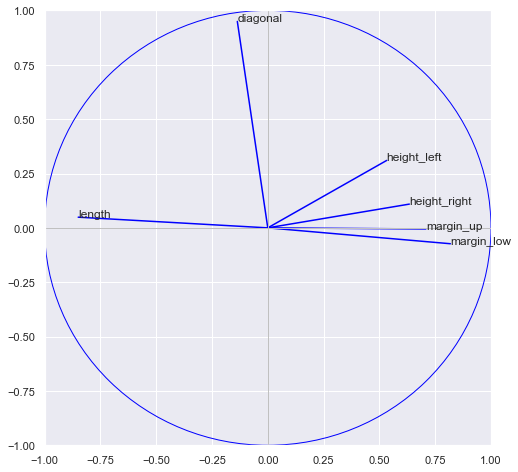

In [31]:
#cercle des corrélations
fig, axes = plt.subplots(figsize=(8,8))
axes.set_xlim(-1,1)
axes.set_ylim(-1,1)
#affichage des étiquettes (noms des variables)
for j in range(6):
   plt.annotate(df_final.iloc[:,1:7].columns[j],(corvar[j,0],corvar[j,1]),size=12)
   plt.plot([0, corvar[j,0]], [0, corvar[j,1]],color='Blue')
#ajouter les axes
plt.plot([-1,1],[0,0],color='silver',linestyle='-',linewidth=1)
plt.plot([0,0],[-1,1],color='silver',linestyle='-',linewidth=1)

#ajouter un cercle
cercle = plt.Circle((0,0),1,color='blue',fill=False)
axes.add_artist(cercle)
#affichage
plt.show()

- F1 est fortement positivement corrélé à margin_low et margin_up, et négativement corrélé à length
- F2 est positivement fortement corrélé à diagonal

In [32]:
#Calcul les données initiales sur les deux axes 
X_projected = pca.transform(X_scaled)
X_projected

array([[ 1.6445244 ,  0.74773053],
       [-2.01970276, -2.20748105],
       [-0.96942494,  2.6205464 ],
       ...,
       [ 1.89034897, -0.60039742],
       [ 1.79045869,  0.51105743],
       [ 1.04264976, -1.47147445]])

In [33]:
# Projection des individus sur les nouveaux axes 
def display_factorial_planes(   X_projected, 
                                x_y, 
                                pca=None, 
                                labels = None,
                                clusters=None, 
                                alpha=1,
                                figsize=[12,12], 
                                marker="." ):
    """
    Affiche la projection des individus

    Positional arguments : 
    -------------------------------------
    X_projected : np.array, pd.DataFrame, list of list : la matrice des points projetés
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2

    Optional arguments : 
    -------------------------------------
    pca : sklearn.decomposition.PCA : un objet PCA qui a été fit, cela nous permettra d'afficher la variance de chaque composante, default = None
    labels : list ou tuple : les labels des individus à projeter, default = None
    clusters : list ou tuple : la liste des clusters auquel appartient chaque individu, default = None
    alpha : float in [0,1] : paramètre de transparence, 0=100% transparent, 1=0% transparent, default = 1
    figsize : list ou tuple : couple width, height qui définit la taille de la figure en inches, default = [10,8] 
    marker : str : le type de marker utilisé pour représenter les individus, points croix etc etc, default = "."
    """

    # Transforme X_projected en np.array
    X_ = np.array(X_projected)

    # On définit la forme de la figure si elle n'a pas été donnée
    if not figsize: 
        figsize = (20,20)

    # On gère les labels
    if  labels is None : 
        labels = []
    try : 
        len(labels)
    except Exception as e : 
        raise e

    # On vérifie la variable axis 
    if not len(x_y) ==2 : 
        raise AttributeError("2 axes sont demandées")   
    if max(x_y )>= X_.shape[1] : 
        raise AttributeError("la variable axis n'est pas bonne")   

    # on définit x et y 
    x, y = x_y

    # Initialisation de la figure       
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # On vérifie s'il y a des clusters ou non
    c = None if clusters is None else clusters
 
    # Les points    
    # plt.scatter(   X_[:, x], X_[:, y], alpha=alpha, 
    #                     c=c, cmap="Set1", marker=marker)
    sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c)

    # Si la variable pca a été fournie, on peut calculer le % de variance de chaque axe 
    if pca : 
        v1 = str(round(100*pca.explained_variance_ratio_[x]))  + " %"
        v2 = str(round(100*pca.explained_variance_ratio_[y]))  + " %"
    else : 
        v1=v2= ''

    # Nom des axes, avec le pourcentage d'inertie expliqué
    ax.set_xlabel(f'F{x+1} {v1}')
    ax.set_ylabel(f'F{y+1} {v2}')

    # Valeur x max et y max
    x_max = np.abs(X_[:, x]).max() *1.1
    y_max = np.abs(X_[:, y]).max() *1.1

    # On borne x et y 
    ax.set_xlim(left=-x_max, right=x_max)
    ax.set_ylim(bottom= -y_max, top=y_max)

    # Affichage des lignes horizontales et verticales
    plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8)
    plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8)

    # Affichage des labels des points
    if len(labels) : 
        for i,(_x,_y) in enumerate(X_[:,[x,y]]):
            plt.text(_x, _y+0.05, labels[i], fontsize='14', ha='center',va='center') 

    # Titre et display
    plt.title(f"Projection des individus (sur F{x+1} et F{y+1})")
    
    plt.show()

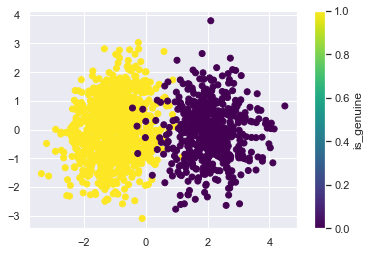

In [34]:
#Affichage du graphique 
x_y = [0,1]


# Création d'un graphique de dispersion avec des couleurs basées sur la colonne 'is_genuine'
plt.scatter(X_projected[:,0], X_projected[:,1], c=df_final.get('is_genuine'), cmap='viridis')

# Ajout du label 'is_genuine' pour la colorbar
plt.colorbar(label='is_genuine')

# Afficher le graphique
plt.show()

On voit dans ce scatter plot, une nette différence entre les vrais et faux billets qui ont l'air fortement dépendants de l'axe F1

In [35]:
# Sélectionner les coordonnées deux premières colonnes (F1 et F2)
X_pca_reduit = pca.fit_transform(X_scaled)[:, :2]

In [36]:
#Ajout des Axes F1 et F2
df_acp=pd.concat([df_final.reset_index(drop=True),pd.DataFrame(X_pca_reduit)],axis=1)

In [37]:
df_acp

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,0,1
0,1,171.81,104.86,104.95,4.52,2.89,112.83,1.644524,0.747731
1,1,171.46,103.36,103.66,3.77,2.99,113.09,-2.019703,-2.207481
2,1,172.69,104.48,103.50,4.40,2.94,113.16,-0.969425,2.620546
3,1,171.36,103.91,103.94,3.62,3.01,113.51,-1.377256,-1.818438
4,1,171.73,104.28,103.46,4.04,3.48,112.54,0.149170,-0.566932
...,...,...,...,...,...,...,...,...,...
1495,0,171.75,104.38,104.17,4.42,3.09,111.28,1.426627,-0.269775
1496,0,172.19,104.63,104.44,5.27,3.37,110.97,3.279949,1.317706
1497,0,171.80,104.01,104.12,5.51,3.36,111.95,1.890349,-0.600397
1498,0,172.06,104.28,104.06,5.17,3.46,112.25,1.790459,0.511057


# Algorithme de classification non supervisée du K-Means

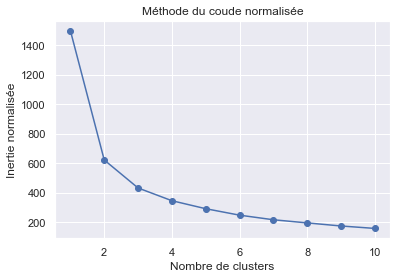

In [38]:
#Méthode du coude normalisée pour avoir le nobmre de clusters optimal

# Calcul de l'inertie pour différentes valeurs 
inertias = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X_projected)
    inertias.append(kmeans.inertia_)
inertias_norm = inertias / np.sum(eigval[:6])
plt.plot(range(1, 11), inertias_norm, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel("Inertie normalisée")
plt.title("Méthode du coude normalisée")
plt.show()

### La méthode du score de Silhouette : Autre méthode de détermination du nombre de clusters

In [39]:
#Importation de la librairie du silhouette score qui permet de déterminer le nombre de clusters

from sklearn.metrics import silhouette_score

# Détermination du nombre maximal de clusters
limit = int((df_acp.shape[0]//2)**0.5)
 
# Détermination du nombre de clusters optimal avec la méthode de Silhouette
for k in range(2, limit+1):
    model_kmeans = KMeans(n_clusters=k)
    model_kmeans.fit(X_projected)
    pred = model_kmeans.predict(X_projected)
    score = silhouette_score(X_projected, pred)
    print('Silhouette Score for k = {}: {:<.3f}'.format(k, score))

Silhouette Score for k = 2: 0.537
Silhouette Score for k = 3: 0.422
Silhouette Score for k = 4: 0.372
Silhouette Score for k = 5: 0.348
Silhouette Score for k = 6: 0.339
Silhouette Score for k = 7: 0.335
Silhouette Score for k = 8: 0.322
Silhouette Score for k = 9: 0.323
Silhouette Score for k = 10: 0.322
Silhouette Score for k = 11: 0.321
Silhouette Score for k = 12: 0.326
Silhouette Score for k = 13: 0.331
Silhouette Score for k = 14: 0.324
Silhouette Score for k = 15: 0.323
Silhouette Score for k = 16: 0.317
Silhouette Score for k = 17: 0.321
Silhouette Score for k = 18: 0.321
Silhouette Score for k = 19: 0.326
Silhouette Score for k = 20: 0.325
Silhouette Score for k = 21: 0.328
Silhouette Score for k = 22: 0.330
Silhouette Score for k = 23: 0.339
Silhouette Score for k = 24: 0.328
Silhouette Score for k = 25: 0.335
Silhouette Score for k = 26: 0.331
Silhouette Score for k = 27: 0.332


- Le score de silhouette est le plus proche de 1 pour k=2. 
- Nous allons utiliser k=2 car nous voulons classifier en deux groupes distincts vrai ou faux

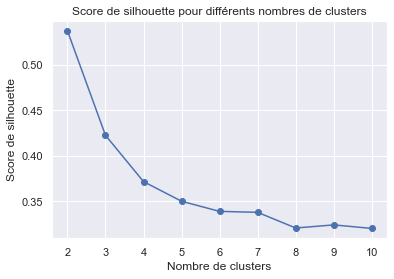

In [40]:
# Calcul du score de silhouette pour différentes valeurs de k
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    cluster_labels = kmeans.fit_predict(X_projected)
    silhouette_scores.append(silhouette_score(X_projected, cluster_labels))

# Tracé de la courbe de score de silhouette
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Score de silhouette')
plt.title('Score de silhouette pour différents nombres de clusters')
plt.show()

# Modélisation du k-Means

En appliquant le PCA aux centroids obtenus dans le K-Means, on projette les centroids dans les nouveaux axes F1 et F2 qui captent la majorité de la variance.

In [41]:
#Données
X = df_final[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']]
y = df_final['is_genuine'] 

In [42]:
# Standardisation des données avec le modèle de scaler sauvegardé 
data_std = scaler.fit_transform(X)

In [43]:
# Séparation des données d'entraînement et de test
X_train_std, X_test_std = train_test_split(data_std, test_size=0.2, random_state=4)

In [44]:
# Application de l'ACP à 2 dimensions
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_std)

# Réduction de la dimensionnalité des données de test à 2 dimensions en utilisant l'ACP
data_pca_test = pca.transform(X_test_std)

# Prédiction des clusters pour les données de test
y_pred_kmeans = model_kmeans.predict(data_pca_test)

In [45]:
# Instanciation Kmeans
model_kmeans = KMeans(n_clusters=2, random_state=4)

In [46]:
#Appliquer la méthode K-means sur les deux premières dimensions de l'ACP avec 2 clusters
df_acp['kmeans_cluster'] = model_kmeans.fit(data_pca)

Nous n'utilisons pas la méthode fit_transform pour appliquer la méthode K-means sur les deux premières dimensions de l'ACP avec 2 clusters. Cela est dû au fait que la méthode fit_transform est utilisée pour effectuer à la fois l'ajustement (fit) et la transformation (transform) des données, ce qui n'est pas nécessaire pour la méthode K-means.

In [47]:
# Visualisation des centroids des clusters
centroids_pca = kmeans.cluster_centers_
centroids = pca.inverse_transform(centroids_pca)

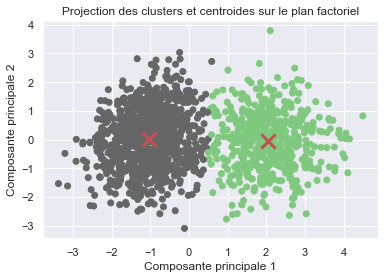

In [48]:
# Affichage des clusters et des centroids
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=model_kmeans.labels_, cmap="Accent")
plt.scatter(model_kmeans.cluster_centers_[:, 0], model_kmeans.cluster_centers_[:, 1], marker='x', s=200, linewidths=3, color='r')
plt.xlabel('Composante principale 1')
plt.ylabel('Composante principale 2')
plt.title('Projection des clusters et centroides sur le plan factoriel')

plt.show()

### Matrice de confusion - KMeans

In [49]:
#Matrice de confusion
from sklearn.metrics import confusion_matrix

y_pred_kmeans = model_kmeans.predict(data_pca_test)

confusion_matrix_kmeans = confusion_matrix(y_test, model_kmeans.predict(data_pca_test))
print(confusion_matrix_kmeans) 

[[103   2]
 [  4 191]]


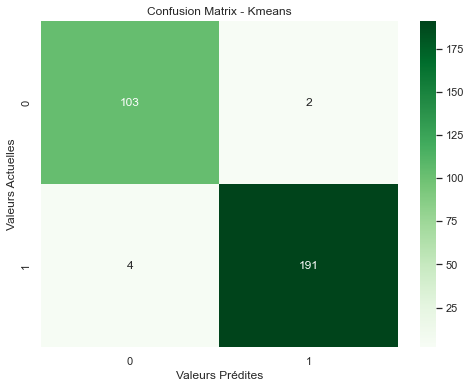

In [50]:
# Affichage du graphique de la matrice de confusion
plt.figure(figsize=(8, 6))

# Matrice de confusion sous forme de heatmap
sns.heatmap(confusion_matrix_kmeans, annot=True, fmt="d", cmap="Greens")

# Ajout des labels pour les axes x et y
plt.xlabel('Valeurs Prédites')
plt.ylabel('Valeurs Actuelles')

# Ajout d'un titre pour le graphique
plt.title('Confusion Matrix - Kmeans')

# Afficher le graphique
plt.show()

In [51]:
# Extraction des valeurs
tn1, fp1, fn1, tp1 = confusion_matrix_kmeans.ravel()

# Affichage
print('Vrais négatifs :', tn1)
print('Vrais positifs :', tp1)
print('Faux négatifs :', fn1)
print('Faux positifs :', fp1)

Vrais négatifs : 103
Vrais positifs : 191
Faux négatifs : 4
Faux positifs : 2


## La courbe ROC

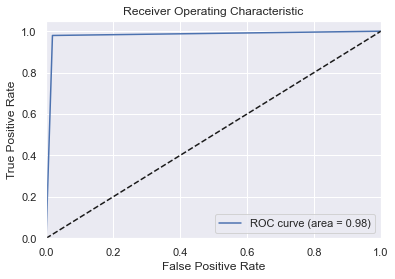

In [52]:
# Calcul de la courbe ROC et l'aire sous la courbe (AUC)
fpr, tpr, thresholds = roc_curve(y_test, model_kmeans.predict(data_pca_test))
auc = roc_auc_score(y_test, model_kmeans.predict(data_pca_test))

# Affichage de la courbe ROC
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [53]:
print("Le score AUC du modèle Kmeans est de", round(auc*100,2), "%")

Le score AUC du modèle Kmeans est de 98.02 %


Avec un score AUC de 98.88% de precision, le modèle de régression logistique est le plus performant dans le cadre de cette étude.

# Sélection de l'algorithme

### Evaluation du meilleur modèle


In [54]:
#On stocke les variables 
X = df_final[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']]
y = df_final['is_genuine']


In [55]:
#Standardisation des données

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.20,
    random_state=4)

#On utilise le scaler sauvegardé

X_train_std = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns = X_train.columns)

X_test_std = pd.DataFrame(
    scaler.transform(X_test),
    columns = X_test.columns)



In [56]:
#Import des librairies de modèles de classification supervisée
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Liste des modèles de classification binaire candidats
models = [RandomForestClassifier(), SVR(), LogisticRegression()]

In [57]:
#Boucle for pour évaluer le MAE et la précision de chaque modèle

for model in models:
    model.fit(X_train_std, y_train)
    predictions = model.predict(X_train_std)
    mae = mean_absolute_error(y_train, predictions)
    print("Pour le modèle", type(model).__name__, "l'Erreur Absolue Moyenne MAE est de", round(mae, 3))
    accuracy_scores = []
    accuracy_scores.append(model.score(X_test_std, y_test))
    print("Pour le modèle", type(model).__name__, "l'accuracy est de", round(accuracy_scores[-1]*100, 3),'%')

Pour le modèle RandomForestClassifier l'Erreur Absolue Moyenne MAE est de 0.0
Pour le modèle RandomForestClassifier l'accuracy est de 98.667 %
Pour le modèle SVR l'Erreur Absolue Moyenne MAE est de 0.069
Pour le modèle SVR l'accuracy est de 92.77 %
Pour le modèle LogisticRegression l'Erreur Absolue Moyenne MAE est de 0.008
Pour le modèle LogisticRegression l'accuracy est de 99.0 %


- En comparant plusieurs modèles de classification supervisée, avec une accuracy à 99% et une Erreur Absolue Moyenne très faible (0.7%), la Regression Logistique est toujours le modèle le plus performant
- Il serait néanmoins judicieux de vérifier également le Random Forest classifier qui semble avoir une très bonne précision
 

# Application de l'agorithme de régression logistique sur billets_production.csv

In [58]:
# Chargement du fichier test
df_test = pd.read_csv(r'C:\Users\franc\Desktop\DATA\PROJET 10 Détectez des faux billets avec R ou Python\livrable\billets_production.csv')

# Séparation des variables prédictives (X_test) de la variable cible (y_test)
X_test = df_test.drop('id', axis=1)
y_test = df_test['id']

# Standardisation des données de test avec le scaler sauvegardé
X_test_std = scaler.fit_transform(X_test)

# Chargement du modèle de regression logistique entraîné 
#(facultatif si c'est sur le même notebook que le modèle sauvegardé)
with open('modele_regression_logistique.pkl', 'rb') as f:
    model = pickle.load(f)

# Prédictions sur les données de test standardisées
y_pred = model.predict(X_test_std)

# Ajout d'une colonne prédiction au DataFrame des données de test
df_test['y_pred'] = y_pred

# Affichage des prédictions
print(df_test)

   diagonal  height_left  height_right  margin_low  margin_up  length   id  \
0    171.76       104.01        103.54        5.21       3.30  111.42  A_1   
1    171.87       104.17        104.13        6.00       3.31  112.09  A_2   
2    172.00       104.58        104.29        4.99       3.39  111.57  A_3   
3    172.49       104.55        104.34        4.44       3.03  113.20  A_4   
4    171.65       103.63        103.56        3.77       3.16  113.33  A_5   

   y_pred  
0       0  
1       0  
2       0  
3       1  
4       1  


In [59]:
# Ajout d'une colonne "prediction" au DataFrame des données de test
df_test['prediction'] = pd.Series(y_pred).map({1: 'Vrai billet', 0: 'Faux billet'})

In [60]:
#Affichage de df_test avec les prédictions
df_test

,diagonal,height_left,height_right,margin_low,margin_up,length,id,y_pred,prediction
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,0,Faux billet
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,0,Faux billet
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,0,Faux billet
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,1,Vrai billet
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,1,Vrai billet


In [61]:
#Nombre de vrai/ faux billets
df_test['prediction'].value_counts()

Faux billet    3
Vrai billet    2
Name: prediction, dtype: int64

# Application de l'agorithme de regression logistique sur de nouvelles données 

In [62]:
# Chargement du fichier test
df_test = pd.read_csv(r'C:\Users\franc\Desktop\DATA\PROJET 10 Détectez des faux billets avec R ou Python\livrable\billets_test.csv')

# Séparation des variables prédictives (X_test) de la variable cible (y_test)
X_test = df_test.drop('id', axis=1)
y_test = df_test['id']

# Standardisation des données de test avec le scaler sauvegardé
X_test_std = scaler.fit_transform(X_test)

# Chargement du modèle de regression logistique entraîné 
#(facultatif si c'est sur le même notebook que le modèle sauvegardé)
with open('modele_regression_logistique.pkl', 'rb') as f:
    model = pickle.load(f)

# Prédictions sur les données de test standardisées
y_pred = model.predict(X_test_std)

# Ajout d'une colonne prédiction au DataFrame des données de test
df_test['y_pred'] = y_pred

# Affichage des prédictions
print(df_test)

   diagonal  height_left  height_right  margin_low  margin_up  length   id  \
0    172.09       103.95        103.73        4.39       3.09  113.19  B_1   
1    171.52       104.17        104.03        5.27       3.16  111.82  B_2   
2    171.78       103.80        103.75        3.81       3.24  113.39  B_3   
3    172.02       104.08        103.99        5.57       3.30  111.10  B_4   
4    171.79       104.34        104.37        5.00       3.07  111.87  B_5   

   y_pred  
0       1  
1       0  
2       1  
3       0  
4       0  


In [63]:
# Ajout d'une colonne "prediction" au DataFrame des données de test
df_test['prediction'] = pd.Series(y_pred).map({1: 'Vrai billet', 0: 'Faux billet'})

In [64]:
#Affichage de df_test avec les prédictions
df_test

,diagonal,height_left,height_right,margin_low,margin_up,length,id,y_pred,prediction
0,172.09,103.95,103.73,4.39,3.09,113.19,B_1,1,Vrai billet
1,171.52,104.17,104.03,5.27,3.16,111.82,B_2,0,Faux billet
2,171.78,103.80,103.75,3.81,3.24,113.39,B_3,1,Vrai billet
3,172.02,104.08,103.99,5.57,3.30,111.10,B_4,0,Faux billet
4,171.79,104.34,104.37,5.00,3.07,111.87,B_5,0,Faux billet


In [65]:
#Nombre de vrais/ faux billets
df_test['prediction'].value_counts()

Faux billet    3
Vrai billet    2
Name: prediction, dtype: int64